# Deep Learning Model Architecture Exploration and Performance Evaluation

#### See the `data_EDA_and_CML_benchmarking.ipynb` notebook for parts 1 and 2, which include the deep learning dataset preparation and CML benchmarking, respectively

## 3.1 Model Architecture Exploration: Justification

##### Overall, the performances of the initial four deep learning models implemented in the `data_EDA_and_CML_benchmarking.ipynb` notebook, which included FCN, CNN, ResNet, and RNN, were poor. Among them, the CNN had the highest accuracy, exceeding 25%. While this value is still low, we will focus on implementing architectures that utilize CNNs, focusing on the three architectures listed below:  

1. VGG16 with Fine-Tuning (a deep CNN)
* *Why?* A VGG16 is a deep CNN with 16 layers that excels at deep feature extraction, effectively capturing complex visual features through small 3x3 convolutional filters. By using pre-trained weights on ImageNet and fine-tuning them on the `PHIPS_CrystalHabitAI_Dataset.nc` image dataset, VGG16 can adapt to our specific classification task, improving performance even with limited data, as the `PHIPS_CrystalHabitAI_Dataset.nc` image dataset is relatively small. The VGG16's depth and fine-tuning capabilities help overcome the low accuracy of initial models by learning more intricate patterns specific to our ice crystal images.

2. InceptionV3 (a different variation of a deep CNN)
* *Why?* This architecture excels at multi-scale feature learning, utilizing Inception modules to process multiple convolutional filter sizes in parallel, capturing visual information at different scales within the same layer. Despite its depth, InceptionV3 is computationally efficient due to techniques like factorized convolutions and dimension reductions, making it suitable for complex datasets without excessive computational cost. Its advanced architecture can extract richer and more diverse features than simpler models, potentially leading to significant improvements in classification accuracy on the `PHIPS_CrystalHabitAI_Dataset.nc` image dataset.

3. Convolutional Recurrent Neural Network (CRNN) with Attention Mechanism (a hyrbid of CNN and RNN)
* *Why?* CRNN integrates Convolutional Neural Networks for spatial feature extraction with Recurrent Neural Networks (like LSTM or GRU) to capture sequential or temporal dependencies in the data. Incorporating attention layers enables the model to focus on the most relevant parts of the input images, enhancing its ability to learn important features and improving classification results. Lastly, this architecture offers a novel solution that goes beyond standard models, potentially capturing complex patterns and relationships in our ice crystal images that previous models may have missed.

#### By using these DL architectures, we will address the low performance of the initial DL models by leveraging deeper networks, advanced feature extraction techniques, and innovative combinations of neural network types tailored to our image classification task. 

## 3.2 Imports and Environment Setup

In [46]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import time 
import time
import json
import os

In [2]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D, MaxPooling2D, 
                                     GlobalAveragePooling2D, Input, SimpleRNN, LSTM, TimeDistributed, 
                                     Bidirectional, Attention)
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate, Resizing, Reshape, Permute, Multiply, Activation, RepeatVector, Lambda

2024-12-03 19:21:22.627503: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 19:21:23.305382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 19:21:23.929335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733282484.450515   51472 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733282484.596789   51472 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:21:25.855145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Sklearn for metrics
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
                             f1_score, precision_score, recall_score, mean_squared_error, roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3.3 Data Loading and Preprocessing
##### organized using a `DatasetLoader` class

In [5]:
class DatasetLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        # Load the dataset using xarray
        ds = xr.open_dataset(self.file_path)
        images = ds['image_array'].values  # Shape: (samples, height, width)
        labels = ds['label'].values        # Shape: (samples,)
        temps = ds['temperature'].values   # Shape: (samples,)
        return images, labels, temps

    def preprocess_data(self, images, labels):
        # Encode string labels into integers
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels)
        num_classes = len(np.unique(labels_encoded))

        # One-hot encode the labels
        labels_one_hot = to_categorical(labels_encoded, num_classes)

        # Expand dimensions of images for channels (grayscale images)
        images_expanded = np.expand_dims(images, axis=-1)  # Shape: (samples, height, width, 1)

        # Normalize images to [0, 1]
        images_normalized = images_expanded / 255.0

        return images_normalized, labels_one_hot, labels_encoded, num_classes, label_encoder

    def split_data(self, images, labels_encoded, labels_one_hot, temps):
        # First split: training set and temp set
        X_train, X_temp, y_train_encoded, y_temp_encoded, y_train_one_hot, y_temp_one_hot, temp_train, temp_temp = train_test_split(
            images, labels_encoded, labels_one_hot, temps, test_size=0.2, random_state=42, stratify=labels_encoded)

        # Second split: validation set and test set
        X_val, X_test, y_val_encoded, y_test_encoded, y_val_one_hot, y_test_one_hot, temp_val, temp_test = train_test_split(
            X_temp, y_temp_encoded, y_temp_one_hot, temp_temp, test_size=0.5, random_state=42, stratify=y_temp_encoded)

        return (X_train, y_train_encoded, y_train_one_hot, temp_train), \
               (X_val, y_val_encoded, y_val_one_hot, temp_val), \
               (X_test, y_test_encoded, y_test_one_hot, temp_test)

In [6]:
# Instantiate the DatasetLoader and load the data
# data_loader = DatasetLoader('/Users/valeriagarcia/Desktop/ESS569_Snowflake_Classification/PHIPS_CrystalHabitAI_Dataset.nc')
data_loader = DatasetLoader('/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc')
images, labels, temps = data_loader.load_data()
images, labels_one_hot, labels_encoded, num_classes, label_encoder = data_loader.preprocess_data(images, labels)

# Split data including temperatures
(X_train, y_train_encoded, y_train_one_hot, temp_train), \
(X_val, y_val_encoded, y_val_one_hot, temp_val), \
(X_test, y_test_encoded, y_test_one_hot, temp_test) = data_loader.split_data(images, labels_encoded, labels_one_hot, temps)

In [7]:
# Check Shapes and Data Types
print("X_train shape:", X_train.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("temp_train shape:", temp_train.shape)
print("Data type of temp_train:", temp_train.dtype)

X_train shape: (352, 1024, 1360, 1)
y_train_one_hot shape: (352, 11)
temp_train shape: (352,)
Data type of temp_train: float64


## 3.4 Data Augmentation
##### Here, we create a data augmentation generator (`data_generator`) for the training data that applies random transformations—including rotations up to 20 degrees, horizontal and vertical shifts up to 10% of the image size, horizontal and vertical flips, zooms up to 10%—to enhance the diversity of the dataset during training.

In [8]:
def data_generator(images, labels_one_hot, temperatures, batch_size, augment=False):
    datagen = ImageDataGenerator(
        rescale=1.0,
        rotation_range=20 if augment else 0,
        width_shift_range=0.1 if augment else 0,
        height_shift_range=0.1 if augment else 0,
        horizontal_flip=augment,
        vertical_flip=augment,
        zoom_range=0.1 if augment else 0
    )
    
    images = np.array(images)
    labels_one_hot = np.array(labels_one_hot)
    temperatures = np.array(temperatures)
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    
    while True:
        if augment:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            x_batch = images[batch_indices]
            y_batch = labels_one_hot[batch_indices]
            temp_batch = temperatures[batch_indices]
            
            # Resize images using the original method
            x_batch_resized = np.empty((x_batch.shape[0], *target_size, x_batch.shape[-1]))
            for i, img in enumerate(x_batch):
                x_batch_resized[i] = tf.image.resize(img, target_size).numpy()
            
            # Apply data augmentation
            x_batch_augmented = np.empty_like(x_batch_resized)
            for i, img in enumerate(x_batch_resized):
                x_batch_augmented[i] = datagen.random_transform(img)
            
            yield (x_batch_augmented, temp_batch), y_batch

# Create data generators
batch_size = 16
target_size = (256, 256) 

train_generator = data_generator(
    X_train, y_train_one_hot, temp_train, batch_size, augment=True
)
val_generator = data_generator(
    X_val, y_val_one_hot, temp_val, batch_size, augment=False
)
test_generator = data_generator(
    X_test, y_test_one_hot, temp_test, batch_size, augment=False
)

In [9]:
# Check if the data generators produce batches with the expected shapes, types, and values

# Fetch a batch from the train generator
(data_batch, temp_batch), label_batch = next(train_generator)

# Compute expected shapes dynamically
expected_data_shape = (batch_size, *target_size, 1)  # Use target_size for dynamic shape calculation
expected_temp_shape = (batch_size,)  # Temperature batch shape
expected_label_shape = (batch_size, y_train_one_hot.shape[1])  # Match number of classes dynamically

# Verify resized shapes
assert data_batch.shape == expected_data_shape, f"Data batch shape mismatch: {data_batch.shape}, expected: {expected_data_shape}"
assert temp_batch.shape == expected_temp_shape, f"Temperature batch shape mismatch: {temp_batch.shape}, expected: {expected_temp_shape}"
assert label_batch.shape == expected_label_shape, f"Label batch shape mismatch: {label_batch.shape}, expected: {expected_label_shape}"

# Print the verified shapes for debugging
print(f"Data batch shape: {data_batch.shape}")
print(f"Temperature batch shape: {temp_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

print("Data generator outputs verified successfully.")


Data batch shape: (16, 256, 256, 1)
Temperature batch shape: (16,)
Label batch shape: (16, 11)
Data generator outputs verified successfully.


2024-12-03 19:22:04.247077: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 3.5 Physics-Informed Loss Function with Probabilistic Class Likelihoods

##### In the cloud microphysics community, it is well-understood from laboratory studies that different ice crystal habits have a tendency to grow within a specific range of temperatures and relative humidity conditions. An example of the different temperature regimes is provided in Varcie et al. 2024:
* *polycrystalline growth layer* (growth of polycrstals) -  may occur when the ambient temperature is below -18˚C
* *dendritic growth layer* (growth of dendrites) - may occur when temperature is warmer than or equal to -18˚C and less than or equal to -12˚C
* *plate growth layer* (growth of plates) - may occur where temperature is warmer than -12˚C and less than -8˚C
* *needle growth layer* (growth of needles) - may occur where temperatures are warmer than or equal to -8˚C and less than -3˚C

##### As our dataset only contains temperature in the metadata, we will focus on leveraging temperature and the temperature regimes above to create a custom loss function. Note the above temperature ranges refer to temperature layers over which certain ice crystals *may* grow, assuming other conditions, such as high ice/water supersaturations, are met. Moreover, particles that growth at cooler temperatures may still be observed at warmer temperatures due to sedimentation of the particles. 

##### Objective: Incorporate temperature-dependent class probabilities into the loss function to guide the model based on physical principles while allowing for natural variability.

In [10]:
#### Create a mapping from class labels to their corresponding temperatures ####

# Get unique class labels
unique_classes = np.unique(labels_encoded)

# Initialize a dictionary to hold temperatures for each class
class_temperatures = {class_idx: [] for class_idx in unique_classes}

# Populate the dictionary
for idx, class_idx in enumerate(labels_encoded):
    temp = temps[idx]
    class_temperatures[class_idx].append(temp)

#### Calculate the mean and standard deviation for the temperatures in each class ####

# Initialize the dictionary to hold temperature statistics for each class
class_temperature_stats = {}

# Compute mean and standard deviation for each class, ignoring NaNs
for class_idx in unique_classes:
    temps_ = np.array(class_temperatures[class_idx])
    
    # Compute mean and standard deviation while ignoring NaNs
    mean_temp = np.nanmean(temps_)
    std_temp = np.nanstd(temps_)
    
    # Handle case where all temps are NaN
    if np.isnan(mean_temp) or np.isnan(std_temp):
        class_temperature_stats[class_idx] = {'mean': np.nan, 'std': np.nan}
    else:
        class_temperature_stats[class_idx] = {'mean': mean_temp, 'std': std_temp}

/tmp/ipykernel_51472/2751809565.py:24: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(temps_)
/home/disk/meso-home/vgarcia1/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [11]:
# Confirm the number of unique classes
actual_num_classes = len(np.unique(labels_encoded))
print(f"Expected num_classes: {num_classes}, Actual num_classes: {actual_num_classes}")

# Ensure consistency
if actual_num_classes != num_classes:
    raise ValueError("Mismatch between num_classes and the actual number of classes in the dataset!")
else:
    print("Number of classes matches the dataset.")

Expected num_classes: 11, Actual num_classes: 11
Number of classes matches the dataset.


In [12]:
# Print the mapping of integer-encoded labels to original class labels
print("Class Mappings (Integer to Original Label):")
for class_idx, class_label in enumerate(label_encoder.classes_):
    print(f"Class {class_idx}: {class_label}")

# Check the number of samples per class in the dataset
print("\nClass Distribution in Dataset:")
unique_classes, class_counts = np.unique(labels_encoded, return_counts=True)
for class_idx, count in zip(unique_classes, class_counts):
    print(f"Class {class_idx}: {count} samples")


Class Mappings (Integer to Original Label):
Class 0: aggregate
Class 1: bullet_rosette
Class 2: capped_column
Class 3: column
Class 4: dendrite
Class 5: graupel
Class 6: needle
Class 7: plate
Class 8: polycrystal
Class 9: side_plane
Class 10: tiny

Class Distribution in Dataset:
Class 0: 40 samples
Class 1: 40 samples
Class 2: 40 samples
Class 3: 40 samples
Class 4: 40 samples
Class 5: 40 samples
Class 6: 40 samples
Class 7: 40 samples
Class 8: 40 samples
Class 9: 40 samples
Class 10: 40 samples


In [13]:
# Verify class temperature statistics
for class_idx, stats in class_temperature_stats.items():
    if np.isnan(stats['mean']) or np.isnan(stats['std']):
        print(f"Class {class_idx}: Temperature stats are missing (mean/std are NaN).")
    else:
        print(f"Class {class_idx}: Mean Temp = {stats['mean']:.2f}, Std Temp = {stats['std']:.2f}")

# Spot-check the temperature values for a specific class
class_to_check = 0  # Replace with a class index to check
print(f"Temperature values for Class {class_to_check}: {class_temperatures[class_to_check]}")

Class 0: Mean Temp = -11.28, Std Temp = 4.97
Class 1: Temperature stats are missing (mean/std are NaN).
Class 2: Mean Temp = -11.40, Std Temp = 2.89
Class 3: Mean Temp = -13.08, Std Temp = 4.77
Class 4: Mean Temp = -14.17, Std Temp = 2.99
Class 5: Mean Temp = -11.17, Std Temp = 4.74
Class 6: Mean Temp = -3.14, Std Temp = 1.18
Class 7: Mean Temp = -9.33, Std Temp = 4.09
Class 8: Mean Temp = -13.55, Std Temp = 4.28
Class 9: Mean Temp = -9.21, Std Temp = 4.76
Class 10: Mean Temp = -8.36, Std Temp = 3.61
Temperature values for Class 0: [-15.21, -15.28, -15.25, -15.23, -15.23, -15.29, -15.34, -15.3, -15.28, -15.11, -15.01, -14.8, -12.16, -15.15, -15.0, -14.85, nan, -15.25, -17.89, -16.53, -16.33, -16.61, -7.67, -5.09, -4.64, -4.32, nan, nan, nan, -5.64, -5.77, -5.69, -5.23, -5.09, -4.9, -4.82, -4.89, -4.72, -4.79, -10.6]


In [14]:
# Check the percentage of NaN temperatures
nan_count = np.isnan(temps).sum()
total_samples = len(temps)
print(f"Number of NaN temperatures: {nan_count}/{total_samples} ({(nan_count/total_samples)*100:.2f}%)")

# Investigate classes with NaN temperatures
for class_idx, temps_ in class_temperatures.items():
    nan_temps = [temp for temp in temps_ if np.isnan(temp)]
    if nan_temps:
        print(f"Class {class_idx} has {len(nan_temps)} NaN temperature(s).")

Number of NaN temperatures: 111/440 (25.23%)
Class 0 has 4 NaN temperature(s).
Class 1 has 40 NaN temperature(s).
Class 2 has 6 NaN temperature(s).
Class 3 has 12 NaN temperature(s).
Class 5 has 1 NaN temperature(s).
Class 6 has 18 NaN temperature(s).
Class 7 has 6 NaN temperature(s).
Class 9 has 17 NaN temperature(s).
Class 10 has 7 NaN temperature(s).


##### The temperature statistics are all NaN for the bullet rosette group (Class 1)

In [15]:
# The get_expected_probs() function calculates the expected class probabilities for each sample in a batch based on its temperature, using Gaussian distributions derived from the class temperature statistics.
# This function will be called within the physics-informed loss function to obtain the expected probabilities based on temperature, which are then used to compute the physics term (e.g., KL divergence).
# Output: Normalized probabilities for each sample in a batch.

def get_expected_probs(temperature_batch, num_classes):
    # Initialize expected probabilities array
    expected_probs = np.zeros((len(temperature_batch), num_classes), dtype=np.float32)
    
    for i, temp in enumerate(temperature_batch):
        total_prob = 0.0
        probs = np.zeros(num_classes, dtype=np.float32)
        
        # Handle NaN temperatures by assigning uniform probabilities
        if np.isnan(temp):
            # Assign uniform probability if temperature is NaN
            probs[:] = 1.0 / num_classes
        else:
            for class_idx in range(num_classes):
                mean = class_temperature_stats[class_idx]['mean']
                std = class_temperature_stats[class_idx]['std']
                
                # Handle classes with NaN mean or std by assigning uniform probability
                if np.isnan(mean) or np.isnan(std):
                    prob = 1.0 / num_classes
                else:
                    # Gaussian probability density function
                    prob = np.exp(-0.5 * ((temp - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
                probs[class_idx] = prob
                total_prob += prob
            
            # Normalize probabilities to sum to 1
            if total_prob > 0:
                probs /= total_prob
            else:
                # If total_prob is zero (unlikely), assign uniform probabilities
                probs[:] = 1.0 / num_classes
        
        expected_probs[i] = probs
    
    return expected_probs

In [16]:
# Combines the categorical cross-entropy loss with a physics-informed KL divergence term.
# This physics-informed loss function will be modified to exclude classes with missing temperature data (e.g., Class 1) from the physics term.

# Define the physics-informed loss function
def physics_informed_loss(y_true, y_pred, temperature):
    # Ensure all inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    temperature = tf.cast(temperature, tf.float32)

    # Standard categorical cross-entropy loss
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y_true, y_pred)

    # Identify samples not belonging to classes with missing temperature stats
    class_indices = tf.argmax(y_true, axis=1)
    valid_class_mask = tf.constant([
        not np.isnan(class_temperature_stats[i]['mean']) for i in range(num_classes)
    ], dtype=tf.bool)

    sample_mask = tf.gather(valid_class_mask, class_indices)
    sample_mask = tf.cast(sample_mask, tf.float32)

    # Compute expected probabilities based on temperature
    expected_probs_np = tf.numpy_function(
        func=get_expected_probs,
        inp=[temperature, num_classes],
        Tout=tf.float32
    )

    # Ensure the shape of expected_probs is defined
    expected_probs = tf.ensure_shape(expected_probs_np, [None, num_classes])  # [batch_size, num_classes]

    # Compute the physics term (KL divergence)
    kl_divergence = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
    physics_term = kl_divergence(expected_probs, y_pred)

    # Apply the mask to exclude invalid samples
    physics_term = physics_term * sample_mask

    # Compute mean physics term over valid samples
    total_valid_samples = tf.reduce_sum(sample_mask) + 1e-7  # Avoid division by zero
    physics_term = tf.reduce_sum(physics_term) / total_valid_samples

    # Total loss with weighting factor
    lambda_weight = 0.1  # Adjust as needed
    total_loss = loss + lambda_weight * physics_term

    # Ensure the total loss is a scalar
    total_loss = tf.reduce_mean(total_loss)
    
    return total_loss

##### Test the loss function with dummy data to ensure it works without errors.

In [17]:
# Set your actual number of classes
num_classes = 11

# Dummy data for testing
y_true_test = tf.one_hot([0, 1], depth=num_classes)
y_pred_test = tf.constant([[0.1]*num_classes, [0.1]*num_classes], dtype=tf.float32)
temp_test = tf.constant([0.0, -5.0], dtype=tf.float32)

# Call the loss function
test_loss = physics_informed_loss(y_true_test, y_pred_test, temp_test)
print("Test loss:", test_loss.numpy())

Test loss: 2.4944966


##### The loss value obtained is reasonable and aligns with the expected calculations given the dummy data. The loss value is relatively high (~2.49) because the predicted probabilities are uniform and do not match the true labels. We have set the predicted probabilities to be uniform across all classes, so predicting the same probability for all classes (especially when incorrect) results in a higher loss.


In [18]:
# Verifying Temperature-Based Loss Function one more time to ensure the function works correctly with model outputs and temperature inputs, using a small batch of dummy data to simulate training and testing scenarios

# Dummy data for verification
dummy_images = np.random.rand(2, 1024, 1360, 1).astype(np.float32)  # 2 grayscale images
dummy_labels = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  # One-hot labels
dummy_temps = np.array([0.0, -5.0], dtype=np.float32)  # 2 temperature values

# Simulate model predictions (random probabilities)
dummy_predictions = np.random.rand(2, 11).astype(np.float32)
dummy_predictions /= np.sum(dummy_predictions, axis=1, keepdims=True)  # Normalize to sum to 1

# Compute the loss
dummy_loss = physics_informed_loss(
    tf.constant(dummy_labels, dtype=tf.float32),
    tf.constant(dummy_predictions, dtype=tf.float32),
    tf.constant(dummy_temps, dtype=tf.float32)
)

print("Dummy Loss Value:", dummy_loss.numpy())

Dummy Loss Value: 2.6170204


##### Lastly, to handle the passing of temperature data to the loss function, we'll use a subclassed model with a custom `train_step`.

In [19]:
class CustomModel(tf.keras.Model):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model

    def train_step(self, data):

        try:
            # Adjust unpacking to handle nested structure
            if len(data) == 3:  # If there are extra elements (e.g., None)
                (x_data, y_batch), _ = data[:2]  # Discard unnecessary parts
            else:
                (x_data, y_batch) = data

            # Further unpack x_data into images and temperature
            x_batch, temp_batch = x_data

            # Proceed with the rest of the train_step logic
            with tf.GradientTape() as tape:
                y_pred = self.model(x_batch, training=True)
                # Compute the loss value
                loss = physics_informed_loss(y_batch, y_pred, temp_batch)

            # Compute gradients
            trainable_vars = self.model.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            # Update metrics
            self.compiled_metrics.update_state(y_batch, y_pred)

            # Return a dict mapping metric names to current value
            return {m.name: m.result() for m in self.metrics}

        except Exception as e:
            print("Error in train_step:", e)
            raise

    def test_step(self, data):

        try:
            # Adjust unpacking to handle nested structure
            if len(data) == 3:  # If there are extra elements (e.g., None)
                (x_data, y_batch), _ = data[:2]  # Discard unnecessary parts
            else:
                (x_data, y_batch) = data

            # Further unpack x_data into images and temperature
            x_batch, temp_batch = x_data

            # Compute predictions
            y_pred = self.model(x_batch, training=False)

            # Compute the loss value
            loss = physics_informed_loss(y_batch, y_pred, temp_batch)

            # Update metrics
            self.compiled_metrics.update_state(y_batch, y_pred)

            # Return a dict mapping metric names to current value
            return {m.name: m.result() for m in self.metrics}

        except Exception as e:
            print("Error in test_step:", e)
            raise

    def call(self, inputs):
        """
        Call method to process inputs during inference.
        Handles both image and temperature inputs.
        """
        try:
            x_batch, temp_batch = inputs  # Unpack the tuple

            return self.model(x_batch, training=False)
        except Exception as e:
            print("Error in call method:", e)
            raise


## 3.6 Model Definitions & Initialization Tests

##### Here, we will define the DL models to be used (e.g., VGG16 with fine-tuning, InceptionV3, CRNN with Attention) with necessary adjustments to accept temperature data where needed.

#### A. VGG16 with Fine-Tuning
**Implementation details:**
* Pre-trained VGG16 Model: Utilize the VGG16 model pre-trained on ImageNet.
* Input Adjustments: Convert grayscale images to RGB by repeating the single channel three times.
* Output Layer: Adjust the final dense layer to match the number of classes.
* Temperature Handling: Temperature data is not fed into the model but provided to the loss function during training.

In [20]:
class VGG16Model:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  # Shape: (height, width, channels)
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        # Input layer for images
        inputs = Input(shape=self.input_shape, name='image_input')

        # Convert grayscale to RGB by repeating channels
        x = Concatenate(axis=-1)([inputs, inputs, inputs])  # Shape: (height, width, 3)

        # Load pre-trained VGG16 model without the top layer and wiht pre-trained weights
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)

        # Freeze base model layers for initial training (to keep pre-trained features during training)
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers on top (more specifically, adds GlobalAveragePooling2D, a dense layer with 256 units and ReLU activation, and an output layer matching the number of classes with softmax activation)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Construct the model
        model = Model(inputs=inputs, outputs=outputs, name='VGG16Model')

        return model

    def compile_model(self):
        # Compilation will be handled in the training step using a custom training loop
        pass  # No action needed here

In [21]:
# Test VGG16Model

# Initialize VGG16 Model using target_size
vgg16_instance = VGG16Model(input_shape=target_size + (1,), num_classes=11)
vgg16_base_model = vgg16_instance.model

# Perform a forward pass with a dummy batch
dummy_images = np.random.rand(2, *target_size, 1).astype(np.float32)  # Match target_size
dummy_output = vgg16_base_model.predict(dummy_images)

# Verify the output shape
assert dummy_output.shape == (2, 11), f"VGG16 output shape mismatch: {dummy_output.shape}"
print("VGG16 forward pass successful.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
VGG16 forward pass successful.


#### B. InceptionV3
**Implementation details:**
* Pre-trained InceptionV3 Model: Utilize the InceptionV3 model pre-trained on ImageNet.
* Input Adjustments: Convert grayscale images to RGB. Also resize images to the expected input size for InceptionV3 (e.g., 299x299).
* Output Layer: Adjust the final dense layer to match the number of classes.
* Temperature Handling: Temperature data is not fed into the model but provided to the loss function during training.

In [22]:
class InceptionV3Model:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  # Original image shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        # Input layer for images
        inputs = Input(shape=self.input_shape, name='image_input')

        # Resize images to 299x299 as expected by InceptionV3
        x = Resizing(299, 299)(inputs)

        # Convert grayscale to RGB
        x = Concatenate(axis=-1)([x, x, x])

        # Load pre-trained InceptionV3 model without the top layer
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

        # Freeze base model layers for initial training
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers on top
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Construct the model
        model = Model(inputs=inputs, outputs=outputs, name='InceptionV3Model')

        return model

    def compile_model(self):
        # Compilation will be handled during training with the custom loss
        pass

In [23]:
# Test InceptionV3Model

# Initialize InceptionV3 Model
inception_instance = InceptionV3Model(input_shape=(*target_size, 1), num_classes=11)
inception_base_model = inception_instance.model

# Perform a forward pass with a dummy batch
dummy_output = inception_base_model.predict(dummy_images)
assert dummy_output.shape == (2, 11), f"InceptionV3 output shape mismatch: {dummy_output.shape}"
print("InceptionV3 forward pass successful.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
InceptionV3 forward pass successful.


#### C. CRNN with Attention Mechanism
**Implementation details:**
* Convolutional Layers: Extract spatial features from images.
* Recurrent Layers (LSTM): Capture sequential dependencies in the extracted features.
* Attention Mechanism: Enhance the model's focus on relevant features.
* Input Adjustments: Use the grayscale images directly.
* Output Layer: Adjust the final dense layer to match the number of classes.
* Temperature Handling: Temperature data is not fed into the model but provided to the loss function during training.

In [24]:
class CRNNModel:
    def __init__(self, input_shape, num_classes, lstm_units=64):
        self.input_shape = input_shape  # Shape: (height, width, channels)
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.model = self.build_model()

    def build_model(self):
        # Input layer for images
        inputs = Input(shape=self.input_shape, name='image_input')

        # Convolutional layers
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Prepare data for LSTM
        shape = K.int_shape(x)  # Use K.int_shape for dynamic dimensions
        x = Reshape((shape[1] * shape[2], shape[3]))(x)  # Shape: (batch_size, timesteps, features)

        # LSTM layer
        x = LSTM(self.lstm_units, return_sequences=True)(x)

        # Attention mechanism
        attention = Dense(1, activation='tanh')(x)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(self.lstm_units)(attention)
        attention = Permute([2, 1])(attention)
        x = Multiply()([x, attention])
        x = Lambda(lambda xin: K.sum(xin, axis=1))(x)

        # Output layer
        outputs = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Construct the model
        model = Model(inputs=inputs, outputs=outputs, name='CRNNModel')

        return model

    def compile_model(self):
        # Compilation will be handled during training with the custom loss
        pass

In [25]:
# Test CRNNModel

# Initialize CRNN Model
crnn_instance = CRNNModel(input_shape=(*target_size, 1), num_classes=11)  # Use target_size for resized dimensions
crnn_base_model = crnn_instance.model

# Perform a forward pass with a dummy batch
dummy_output = crnn_base_model.predict(dummy_images)
assert dummy_output.shape == (2, 11), f"CRNN output shape mismatch: {dummy_output.shape}"
print("CRNN forward pass successful.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
CRNN forward pass successful.


In [26]:
# Verify CustomModel Training Logic
# Use the CustomModel subclass with one architecture to ensure the train_step and test_step execute without errors

# Wrap VGG16 model with CustomModel
vgg16_model = CustomModel(vgg16_base_model)

# Compile the model using the custom physics-informed loss
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, temp_batch),
    metrics=['accuracy']
)

# Fetch a batch
(data_batch, temp_batch), label_batch = next(train_generator)

# Perform one training step
train_results = vgg16_model.train_on_batch(((data_batch, temp_batch), label_batch))
print("CustomModel training step successful. Results:", train_results)

# Perform one testing step
test_results = vgg16_model.test_on_batch(((data_batch, temp_batch), label_batch))
print("CustomModel testing step successful. Results:", test_results)

/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py:639: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


CustomModel training step successful. Results: [array(0.09090909, dtype=float32), {'accuracy': array(0.125, dtype=float32)}]
CustomModel testing step successful. Results: [array(0.09090909, dtype=float32), {'accuracy': array(0.1875, dtype=float32)}]


## 3.7 Compliling the Models

In [27]:
# Defining a class to compute F1-score TensorFlow does not provide a built-in F1 score metric
class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Defining a class to compute RMSE since TensorFlow does not provide a built-in RMSE metric
class RMSEMetric(tf.keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super(RMSEMetric, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros", dtype=tf.float32)
        self.count = self.add_weight(name="count", initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure both inputs are float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Compute squared error
        squared_error = tf.square(y_true - y_pred)

        # Update the total squared error and count
        self.total.assign_add(tf.reduce_sum(squared_error))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        # Compute RMSE
        mean_squared_error = self.total / (self.count + 1e-7)
        return tf.sqrt(mean_squared_error)

    def reset_states(self):
        # Reset the total and count
        self.total.assign(0.0)
        self.count.assign(0.0)


#### A. VGG16 Model

In [28]:
# Wrap the VGG16 model in the CustomModel class
vgg16_custom_model = CustomModel(vgg16_base_model)

# Initialize the custom metrics
f1_score_metric = F1ScoreMetric()
rmse_metric = RMSEMetric()

# Compile the VGG16 model with F1-score and RMSE metrics
vgg16_custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score_metric,  # F1-score custom metric
        rmse_metric,      # RMSE custom metric
        'accuracy'        # Accuracy as a baseline metric
    ]
)

print("VGG16 model compiled successfully with F1-score and RMSE metrics.")

VGG16 model compiled successfully with F1-score and RMSE metrics.


#### B. InceptionV3 Model

In [29]:
# Wrap the InceptionV3 model in the CustomModel class
inception_custom_model = CustomModel(inception_base_model)

# Compile the InceptionV3 model with F1-score and RMSE metrics
inception_custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score_metric,  # F1-score custom metric
        rmse_metric,      # RMSE custom metric
        'accuracy'        # Accuracy as a baseline metric
    ]
)

print("InceptionV3 model compiled successfully with F1-score and RMSE metrics.")

InceptionV3 model compiled successfully with F1-score and RMSE metrics.


#### C. CRNN Model

In [30]:
# Wrap the CRNN model in the CustomModel class
crnn_custom_model = CustomModel(crnn_base_model)

# Compile the CRNN model with F1-score and RMSE metrics
crnn_custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score_metric,  # F1-score custom metric
        rmse_metric,      # RMSE custom metric
        'accuracy'        # Accuracy as a baseline metric
    ]
)

print("CRNN model compiled successfully with F1-score and RMSE metrics.")

CRNN model compiled successfully with F1-score and RMSE metrics.


## 3.8 Training the Models (baseline before parameter tuning)

In [31]:
# Define EarlyStopping to prevent overfitting (stops training when validation loss stops improving)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

#### A. VGG16 Model

In [32]:
# Start tracking time
start_time = time.time()

# Train the VGG16 Custom Model
vgg16_history = vgg16_custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Calculate training time
vgg16_training_time = time.time() - start_time
print(f"VGG16 Training Time: {vgg16_training_time:.2f} seconds")

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.2147 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2844 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.4785 - f1_score: 0.0053 - precision: 0.6087 - recall: 0.0026 - rmse: 0.2717 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.5417 - f1_score: 0.0237 - precision: 0.7391 - recall: 0.0121 - rmse: 0.2577 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.5646 - f1_score: 0.1184 - precision: 0.9952 - recall: 0.0640 - rmse: 0.2443 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.6338 - f1_score: 0.2898 - precision: 1.0000 - recall: 0.1700 - rmse: 0.2323 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7355 - f1_score: 0.1988 - precision: 0.8610 - recall: 

#### B. InceptionV3 Model

In [33]:
# Start tracking time
start_time = time.time()

# Train the InceptionV3 Custom Model
inception_history = inception_custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Calculate training time
inception_training_time = time.time() - start_time
print(f"InceptionV3 Training Time: {inception_training_time:.2f} seconds")


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2584 - f1_score: 0.2347 - precision: 0.3965 - recall: 0.0417 - rmse: 0.2602 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7407 - f1_score: 0.5832 - precision: 0.9070 - recall: 0.4348 - rmse: 0.1947 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7852 - f1_score: 0.7816 - precision: 0.8604 - recall: 0.7163 - rmse: 0.1628 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8889 - f1_score: 0.8458 - precision: 0.9385 - recall: 0.7701 - rmse: 0.1382 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8645 - f1_score: 0.8632 - precision: 0.9305 - recall: 0.8053 - rmse: 0.1332 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8375 - f1_score: 0.8302 - precision: 0.9008 - recall: 0.7701 - rms

#### C. CRNN Model 

In [34]:
# Start tracking time
start_time = time.time()

# Train the CRNN Custom Model
crnn_history = crnn_custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Calculate training time
crnn_training_time = time.time() - start_time
print(f"CRNN Training Time: {crnn_training_time:.2f} seconds")



Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.0753 - f1_score: 0.2164 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2696 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.0619 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2875 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.0693 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2870 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2099 - f1_score: 0.0067 - precision: 0.6957 - recall: 0.0034 - rmse: 0.2821 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2235 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2761 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2108 - f1_score: 0.018

#### Log training time of the models

In [35]:
# Save training histories and training times

# Convert histories to plain Python objects for JSON serialization
def serialize_history(history):
    return {key: [float(value) for value in values] for key, values in history.items()}

# Save training histories and training times
baseline_results = {
    'vgg16': {
        'history': vgg16_history.history,
        'training_time': vgg16_training_time
    },
    'inception': {
        'history': inception_history.history,
        'training_time': inception_training_time
    },
    'crnn': {
        'history': crnn_history.history,
        'training_time': crnn_training_time
    }
}

# Save results to a JSON file
output_file = 'DL_baseline_training_results.json'
with open(output_file, 'w') as f:
    json.dump(baseline_results, f, indent=4)

print(f"Training results saved to {output_file}")

Training results saved to DL_baseline_training_results.json


## 3.9 Training the Models (now with parameter tuning)
##### Here, we chose a few hyperparameters to tune for each model:
* VGG16: Learning rate, number of dense units
* InceptionV3: Learning rate, number of dense units
* CRNN: Learning rate, LSTM units

#### Definitions:
1. **Learning Rate:** determines the step size for updating the model's weights during optimization. A high learning rate can lead to rapid convergence but risks overshooting the optimal point, while a low learning rate ensures stability but may slow down convergence or get stuck in local minima. Proper tuning balances speed and accuracy.
2. **Number of dense units:** number of units in dense (fully connected) layers defines the network's capacity to learn complex representations. More units increase the model's ability to capture nuanced patterns but risk overfitting and higher computational cost. Fewer units may lead to underfitting, where the model struggles to capture the data's complexity.
3. **LSTM Units:** the number of LSTM (Long Short-Term Memory) units in recurrent layers determines the model's memory capacity for sequential dependencies. More units allow the model to retain and process longer-term patterns but increase the risk of overfitting and slower training. Fewer units may result in insufficient sequence learning.


In [36]:
# Define a generalized training function to run training for a specific model with given hyperparameters and save the results.

def train_with_params(model, model_name, params, train_gen, val_gen, batch_size):
    start_time = time.time()

    # Unpack hyperparameters
    learning_rate = params.get("learning_rate", 1e-3)
    dense_units = params.get("dense_units", 256)
    lstm_units = params.get("lstm_units", 64)

    # Adjust model architecture if needed
    if model_name == "VGG16" or model_name == "InceptionV3":
        # Locate the Dense layer using the model tree
        dense_layer_found = False
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                layer.units = dense_units
                dense_layer_found = True
                break
            elif hasattr(layer, 'layers'):  # For nested models
                for nested_layer in layer.layers:
                    if isinstance(nested_layer, tf.keras.layers.Dense):
                        nested_layer.units = dense_units
                        dense_layer_found = True
                        break
        if not dense_layer_found:
            raise ValueError(f"No Dense layer found in {model_name} for adjustment.")
        
    elif model_name == "CRNN":
        # Rebuild CRNN model
        print(f"Rebuilding CRNN model with lstm_units={lstm_units} and dense_units={dense_units}")
        rebuilt_model = CRNNModel(
            input_shape=target_size + (1,),
            num_classes=11,
            lstm_units=lstm_units  # Update LSTM units
        ).model
        # Wrap the rebuilt model in CustomModel
        model = CustomModel(rebuilt_model)

    # Recompile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            F1ScoreMetric(),  # Custom F1-score class
            RMSEMetric(),  # Custom RMSE class
            "accuracy"  # Baseline accuracy
        ]
    )

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        steps_per_epoch=len(X_train) // batch_size,
        validation_steps=len(X_val) // batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    training_time = time.time() - start_time

    # Return the results
    return {
        "history": history.history,
        "training_time": training_time
    }

#### A. VGG16 

In [37]:
# Define hyperparameters to tune
vgg16_params_list = [
    {"learning_rate": 1e-3, "dense_units": 128},
    {"learning_rate": 1e-4, "dense_units": 256},
    {"learning_rate": 1e-5, "dense_units": 512}
]

# Train the VGG16 model for each parameter set
vgg16_tuning_results = []
for params in vgg16_params_list:
    print(f"Tuning VGG16 with params: {params}")
    result = train_with_params(
        vgg16_custom_model, "VGG16", params, train_generator, val_generator, batch_size
    )
    vgg16_tuning_results.append({"params": params, "result": result})

Tuning VGG16 with params: {'learning_rate': 0.001, 'dense_units': 128}
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.3340 - f1_score: 0.0061 - precision: 0.3043 - recall: 0.0031 - rmse: 0.2729 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.5376 - f1_score: 0.0132 - precision: 0.5217 - recall: 0.0067 - rmse: 0.2593 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6399 - f1_score: 0.0462 - precision: 0.8261 - recall: 0.0239 - rmse: 0.2436 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6314 - f1_score: 0.1421 - precision: 0.9388 - recall: 0.0773 - rmse: 0.2369 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.6968 - f1_score: 0.3095 - precision: 0.9853 - recall: 0.1854 - rmse: 0.2233 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accurac

#### B. InceptionV3 

In [38]:
# Define hyperparameters to tune for InceptionV3
inception_params_list = [
    {"learning_rate": 1e-3, "dense_units": 128},
    {"learning_rate": 1e-4, "dense_units": 256},
    {"learning_rate": 1e-5, "dense_units": 512}
]

# Train the InceptionV3 model for each parameter set
inception_tuning_results = []
for params in inception_params_list:
    print(f"Tuning InceptionV3 with params: {params}")
    result = train_with_params(
        inception_custom_model, "InceptionV3", params, train_generator, val_generator, batch_size
    )
    inception_tuning_results.append({"params": params, "result": result})


Tuning InceptionV3 with params: {'learning_rate': 0.001, 'dense_units': 128}
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7169 - f1_score: 0.5812 - precision: 0.8271 - recall: 0.4514 - rmse: 0.2061 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7780 - f1_score: 0.7675 - precision: 0.8820 - recall: 0.6794 - rmse: 0.1692 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8701 - f1_score: 0.8353 - precision: 0.9241 - recall: 0.7628 - rmse: 0.1424 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8564 - f1_score: 0.8415 - precision: 0.9095 - recall: 0.7833 - rmse: 0.1412 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8981 - f1_score: 0.8689 - precision: 0.9402 - recall: 0.8079 - rmse: 0.1310 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - a

#### C. CRNN 

In [39]:
# Define hyperparameters to tune for CRNN
crnn_params_list = [
    {"learning_rate": 1e-3, "dense_units": 256, "lstm_units": 64},
    {"learning_rate": 1e-4, "dense_units": 512, "lstm_units": 128},
    {"learning_rate": 1e-5, "dense_units": 128, "lstm_units": 32}
]

# Train the CRNN model for each parameter set
crnn_tuning_results = []
for params in crnn_params_list:
    print(f"Tuning CRNN with params: {params}")
    result = train_with_params(
        None, "CRNN", params, train_generator, val_generator, batch_size
    )
    crnn_tuning_results.append({"params": params, "result": result})


Tuning CRNN with params: {'learning_rate': 0.001, 'dense_units': 256, 'lstm_units': 64}
Rebuilding CRNN model with lstm_units=64 and dense_units=256


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.0971 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2875 - loss: 0.0909 - val_loss: 0.0909
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.0995 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2874 - loss: 0.0909 - val_loss: 0.0909
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1274 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2861 - loss: 0.0909 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1948 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2802 - loss: 0.0909 - val_loss: 0.0909
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1941 - f1_score: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - rmse: 0.2767 - loss: 0.0909 - val_loss: 0.0909
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.2435 -

#### Saving all tuning results

In [40]:
# Save all tuning results to a JSON file
tuning_results = {
    "vgg16_tuning": vgg16_tuning_results,
    "inception_tuning": inception_tuning_results,
    "crnn_tuning": crnn_tuning_results
}

with open("DL_tuning_training_results.json", "w") as f:
    json.dump(tuning_results, f)

print("All tuning results saved successfully.")


All tuning results saved successfully.


In [43]:
# Function to rebuild, compile, and wrap the best models (for model performance evaluations)
def get_best_model(model_name, tuning_results, base_model_class, additional_params=None):
    # Identify the best tuning result
    best_result = max(tuning_results[model_name], key=lambda x: max(x["result"]["history"]["accuracy"]))
    best_params = best_result["params"]

    # Rebuild the model with best parameters
    print(f"Rebuilding {model_name} with params: {best_params}")
    if model_name == "CRNN":
        best_base_model = base_model_class(
            input_shape=target_size + (1,),
            num_classes=11,
            lstm_units=best_params.get("lstm_units", 64)
        ).model
    else:  # VGG16 or InceptionV3
        best_base_model = base_model_class(
            input_shape=target_size + (1,),
            num_classes=11
        ).model
        if additional_params:
            for layer in best_base_model.layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    layer.units = best_params.get("dense_units", 256)
                    break

    # Wrap the rebuilt model in CustomModel
    best_model = CustomModel(best_base_model)

    # Compile the model
    best_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params.get("learning_rate", 1e-3)),
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            F1ScoreMetric(),
            RMSEMetric(),
            "accuracy"
        ]
    )
    return best_model

# Define the best models
best_vgg16_model = get_best_model("vgg16_tuning", tuning_results, VGG16Model)
best_inception_model = get_best_model("inception_tuning", tuning_results, InceptionV3Model)
best_crnn_model = get_best_model("crnn_tuning", tuning_results, CRNNModel)

# Print confirmation
print("Best models for VGG16, Inception, and CRNN are successfully rebuilt, wrapped, and compiled.")

Rebuilding vgg16_tuning with params: {'learning_rate': 0.001, 'dense_units': 128}
Rebuilding inception_tuning with params: {'learning_rate': 0.001, 'dense_units': 128}
Rebuilding crnn_tuning with params: {'learning_rate': 0.001, 'dense_units': 256, 'lstm_units': 64}
Best models for VGG16, Inception, and CRNN are successfully rebuilt, wrapped, and compiled.


## 4.1 Model Performance: Quantitative Evaluation

In [44]:
# Load baseline results
baseline_results = {
    "VGG16": {"history": vgg16_history.history, "training_time": vgg16_training_time},
    "Inception": {"history": inception_history.history, "training_time": inception_training_time},
    "CRNN": {"history": crnn_history.history, "training_time": crnn_training_time},
}

# Load parameter tuning results
tuning_results = {
    "VGG16": vgg16_tuning_results,
    "Inception": inception_tuning_results,
    "CRNN": crnn_tuning_results,
}

In [47]:
# Compare metrics like accuracy, precision, recall, F1-score, RMSE, and training time.

print("\n=== Baseline vs. Tuning Comparison ===")

models = ["VGG16", "Inception", "CRNN"]
metrics_to_compare = ["accuracy", "precision", "recall", "f1_score", "rmse"]

# Define baseline parameters for reference
baseline_params = {
    "VGG16": {"learning_rate": 1e-3, "dense_units": 256},
    "Inception": {"learning_rate": 1e-3, "dense_units": 256},
    "CRNN": {"learning_rate": 1e-3, "dense_units": 256, "lstm_units": 64}
}

for model_name in models:
    print(f"\nModel: {model_name}")
    print("-" * 40)
    
    # Baseline metrics
    baseline = baseline_results[model_name]
    baseline_metrics = {metric: max(baseline["history"].get(metric, [0])) for metric in metrics_to_compare}
    baseline_time = baseline["training_time"]
    print(f"Baseline Metrics: {baseline_metrics}")
    print(f"Baseline Training Time: {baseline_time:.2f} seconds")
    print(f"Baseline Parameters: {baseline_params[model_name]}\n")  # Include baseline parameters
    
    # Best tuned metrics
    best_tuned_result = max(tuning_results[model_name], key=lambda x: max(x["result"]["history"].get("val_accuracy", [0])))
    best_params = best_tuned_result["params"]
    best_tuned_metrics = {metric: max(best_tuned_result["result"]["history"].get(metric, [0])) for metric in metrics_to_compare}
    best_tuned_time = best_tuned_result["result"]["training_time"]
    
    print(f"Tuned Metrics (Best): {best_tuned_metrics}")
    print(f"Tuned Training Time: {best_tuned_time:.2f} seconds")
    print(f"Best Parameters: {best_params}")


=== Baseline vs. Tuning Comparison ===

Model: VGG16
----------------------------------------
Baseline Metrics: {'accuracy': 0.90625, 'precision': 1.0, 'recall': 0.53125, 'f1_score': 0.6799999475479126, 'rmse': 0.274233877658844}
Baseline Training Time: 939.89 seconds
Baseline Parameters: {'learning_rate': 0.001, 'dense_units': 256}

Tuned Metrics (Best): {'accuracy': 0.84375, 'precision': 1.0, 'recall': 0.5625, 'f1_score': 0.6923075914382935, 'rmse': 0.2610202431678772}
Tuned Training Time: 947.23 seconds
Best Parameters: {'learning_rate': 0.001, 'dense_units': 128}

Model: Inception
----------------------------------------
Baseline Metrics: {'accuracy': 0.7857142686843872, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.7777777314186096, 'rmse': 0.21771122515201569}
Baseline Training Time: 322.01 seconds
Baseline Parameters: {'learning_rate': 0.001, 'dense_units': 256}

Tuned Metrics (Best): {'accuracy': 0.8125, 'precision': 0.95652174949646, 'recall': 0.71875, 'f1_score': 0.8070175

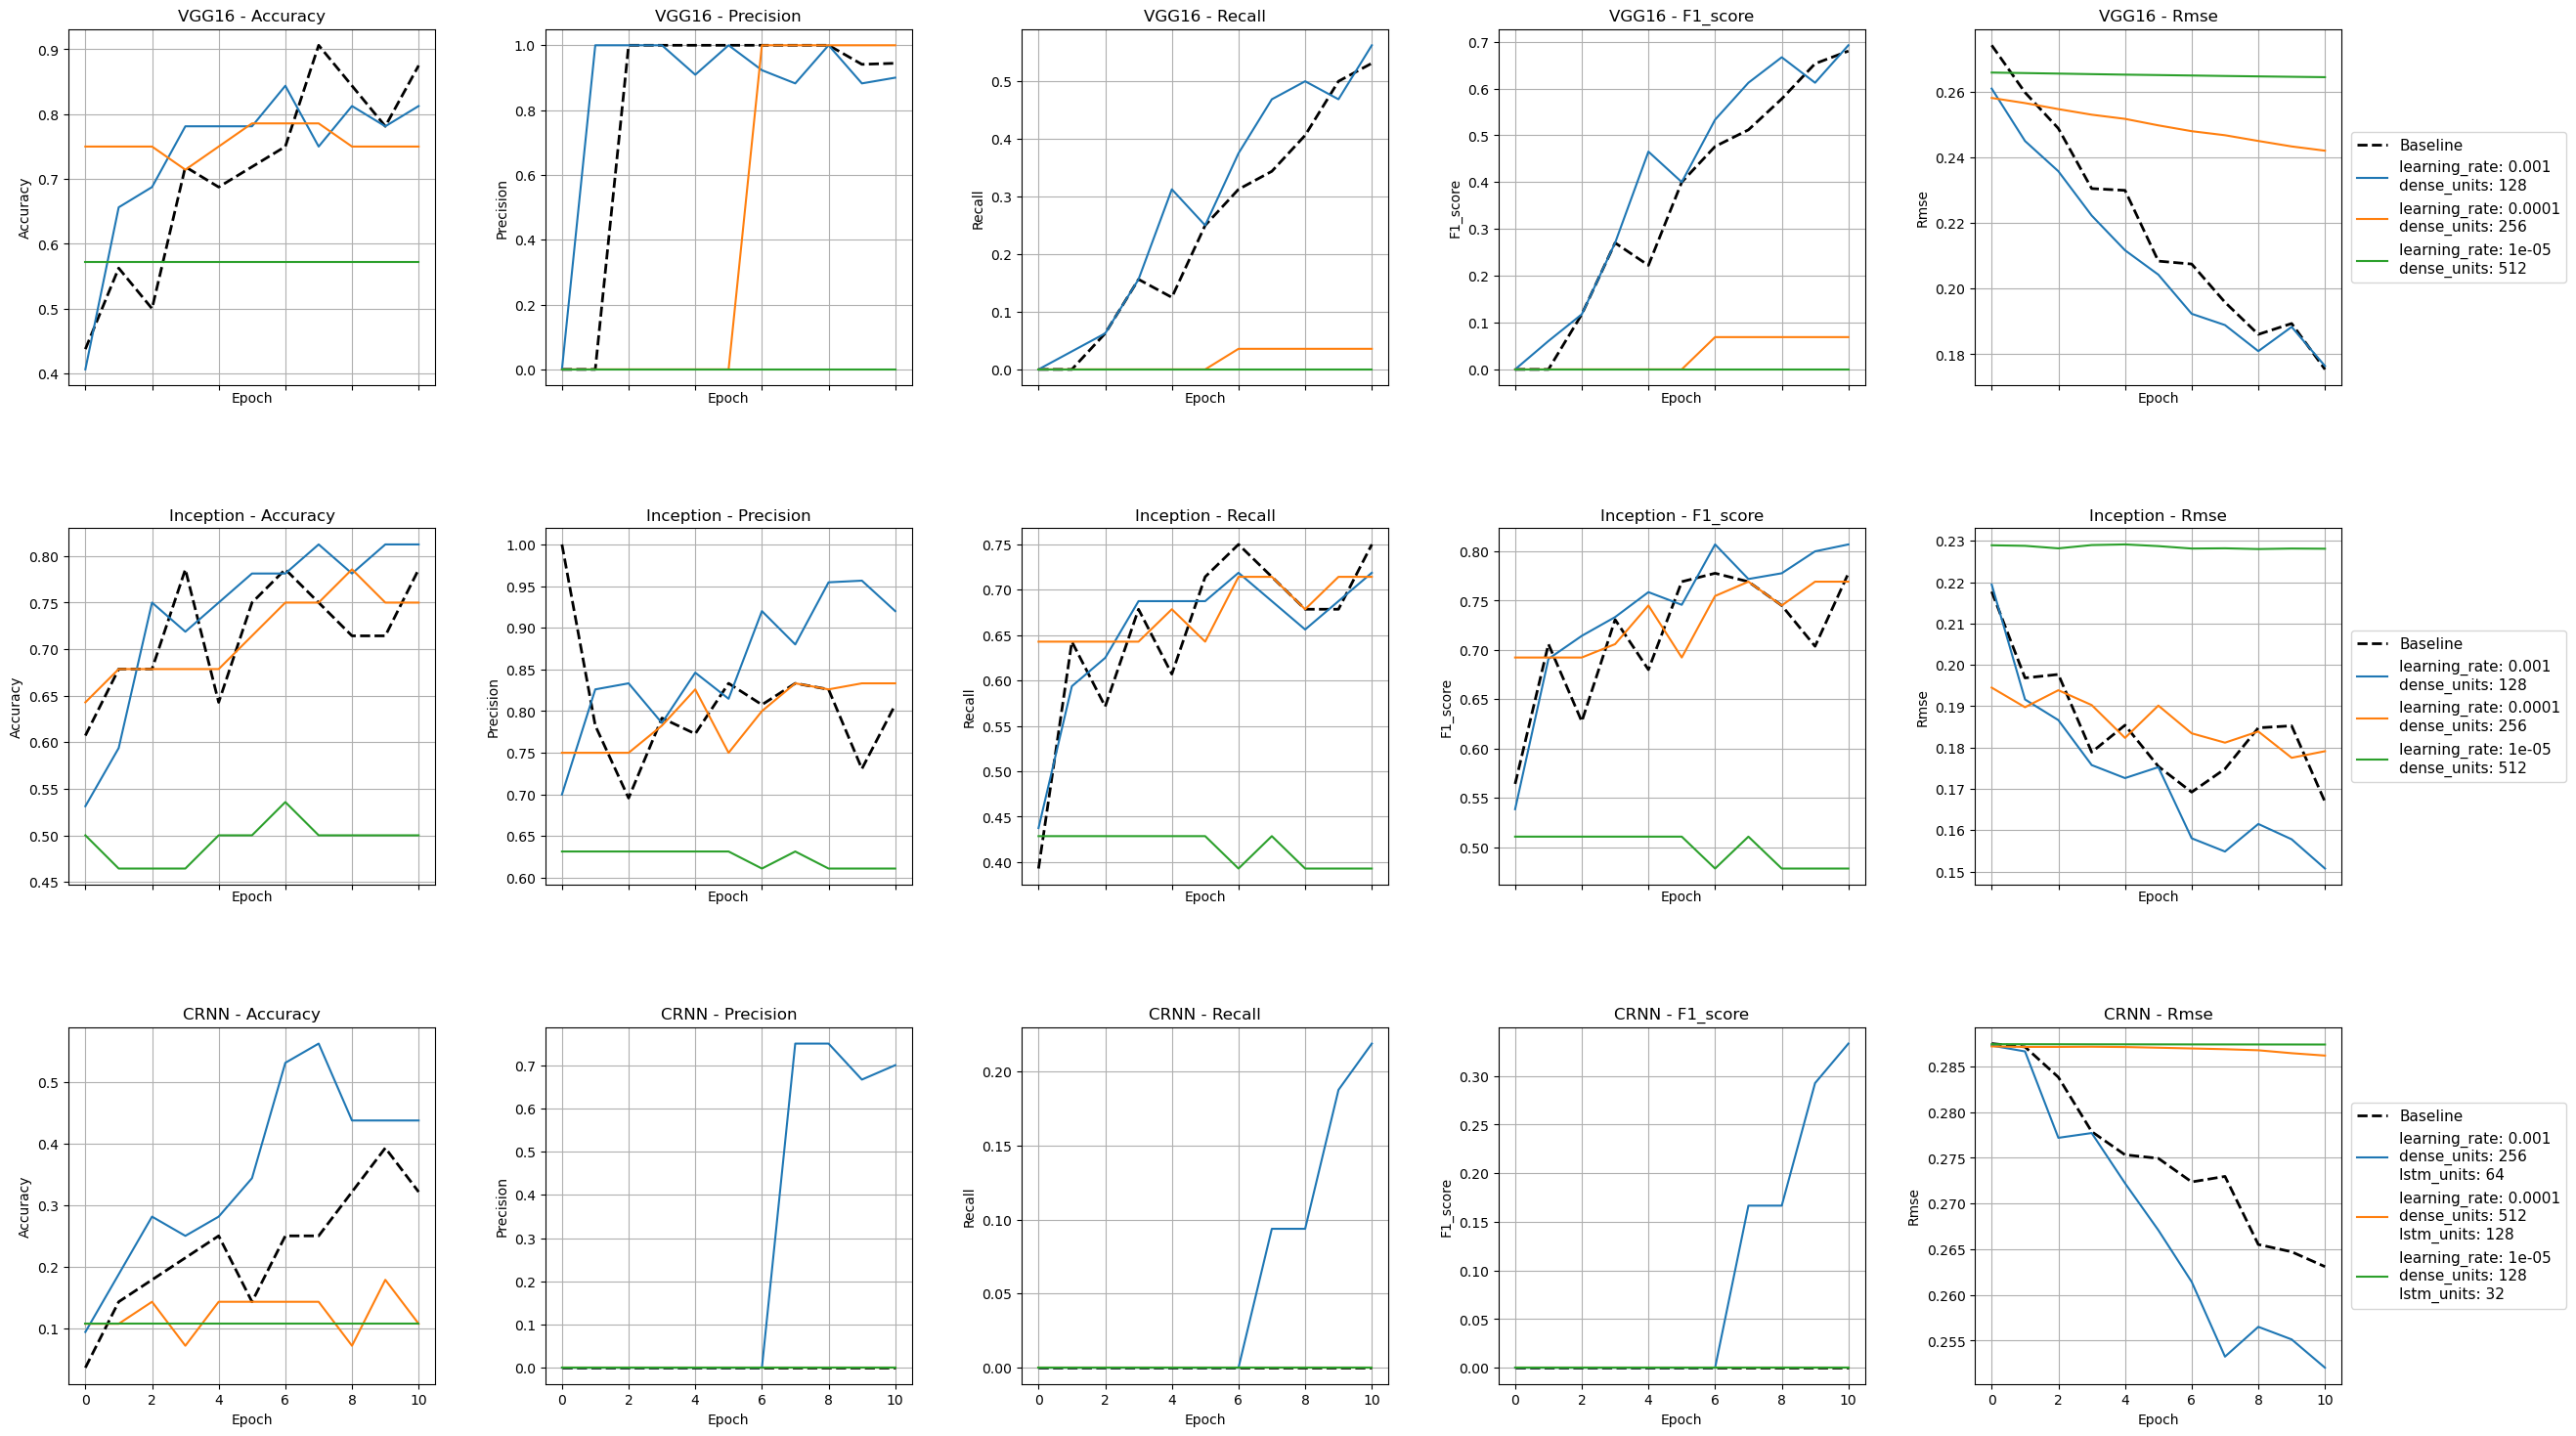

In [48]:
# Generate comparison plots
def plot_comparisons_subplots(baseline_results, tuning_results, metrics):
    models = ["VGG16", "Inception", "CRNN"]
    num_models = len(models)
    num_metrics = len(metrics)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_models, num_metrics, figsize=(30, 6 * num_models), sharex=True, sharey=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    # Iterate over models and metrics
    for i, model_name in enumerate(models):
        handles = {}
        for j, metric in enumerate(metrics):
            ax = axes[i, j] if num_models > 1 else axes[j]  # Handle single-row case
            
            # Extract baseline metric
            baseline_metric = baseline_results[model_name]["history"].get(metric, [0])
            
            # Extract tuning metrics
            tuning_metrics = [
                result["result"]["history"].get(metric, [0]) for result in tuning_results[model_name]
            ]
            tuning_labels = [
                "\n".join(
                    f"{key}: {value}" for key, value in result["params"].items()
                ) for result in tuning_results[model_name]  # Break labels into multiple lines
            ]
            
            # Plot baseline metric
            baseline_line, = ax.plot(baseline_metric, label="Baseline", linestyle="--", linewidth=2, color="black")
            if "Baseline" not in handles:
                handles["Baseline"] = baseline_line
            
            # Plot tuning metrics
            for tuning_metric, label in zip(tuning_metrics, tuning_labels):
                tuning_line, = ax.plot(tuning_metric, label=f"Tuned: {label}")
                if label not in handles:
                    handles[label] = tuning_line
            
            # Set plot titles and labels
            ax.set_title(f"{model_name} - {metric.capitalize()}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(metric.capitalize())
            ax.grid()

        # Add a single legend for the entire row, aligned with the last subplot
        unique_handles = list(handles.values())
        unique_labels = list(handles.keys())
        
        # Adjust legend placement for alignment with the last subplot in the row
        ax_last = axes[i, -1] if num_metrics > 1 else axes[-1]
        bbox = ax_last.get_position()
        legend_x = bbox.x1 + 0.04  # Offset to the right of the last subplot
        legend_y = (bbox.y0 + bbox.y1) / 2  # Center vertically in the row
        fig.legend(
            unique_handles, unique_labels, loc="center", fontsize=11,
            bbox_to_anchor=(legend_x, legend_y), bbox_transform=fig.transFigure
        )

    plt.show()

# Call the function with metrics
metrics_to_plot = ["accuracy", "precision", "recall", "f1_score", "rmse"]
plot_comparisons_subplots(baseline_results, tuning_results, metrics_to_plot)

##### DEFINE THE METRICS USED DURING EVALUATION PROCESS (PRECISION, RECALL, F1 SCORE), THEN INSERT DISCUSSION ON COMPARISON OF DIFFERENT MODELS AND PARAMETER TUNING USING THE GRAPHS ABOVE/TABLE. 

##### Optional (but will be required in the presentation): compare these metrics with the CML performances

## 4.2 Model Performance: Generalization Testing
##### Even though we compiled the models to run for 20 epochs, the EarlyStopping function stopped the training when the validation loss stopped improving after 10 epochs. This occured for all runs and models, suggesting that perhaps the models tended to overfit (hence the lack of validation loss improvement)

## 4.3 Discussion on Narrow vs. General AI
##### INSERT DISCUSSION REFLECTING ON THE ROLE OF THE IMPLEMENTED DL MODELS AS NARROW AI AND CONSTRAST IT WITH BROADER CONCEPT OF GENERAL AI, TYING DISCUSSION TO THE PROBLEM DOMAIN AND DATASET